<div class="alert alert-block alert-info">
<span style="color: rgb(0,53,91);">
<center><img src="https://imgs.search.brave.com/vIujYFx1qV5CoxJb72HNVYIoBXQjuasIvdngB1DPC3s/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly91cGxv/YWQud2lraW1lZGlh/Lm9yZy93aWtpcGVk/aWEvZW4vdGh1bWIv/NS81Zi9XZXN0ZXJu/X0luc3RpdHV0ZV9v/Zl9UZWNobm9sb2d5/X2FuZF9IaWdoZXJf/RWR1Y2F0aW9uX2xv/Z28ucG5nLzIwMHB4/LVdlc3Rlcm5fSW5z/dGl0dXRlX29mX1Rl/Y2hub2xvZ3lfYW5k/X0hpZ2hlcl9FZHVj/YXRpb25fbG9nby5w/bmc" style="width:180px;height:142px;" title="Logo ITESO"></center>
<font face = "Times New Roman" size = "6"><b><center>Programacion para Mineria de Datos</center></b></font>
<font face = "Times New Roman" size = "5"><b><center>TAREA: Fuga de Datos</center></b></font>

<b><font back = "Times New Roman" size = "4"><center>Unidad 4: </center></font>
<font face = "Times New Roman" size = "4"><center>Tema 4.3: Integración de Datos: Categóricos, Numéricos, Faltantes y Fuga de Datos</center></font>

<b><font back = "Times New Roman" size = "4"><center>Equipo: </center></font>
<font face = "Times New Roman" size = "4"><center> Diego Lemus, Sebastian Zinchenko, Jersus Vargas </center></font>

<div align="right"><font face = "Times New Roman" size = "2">Mtro. Miguel Tlapa Juarez (migueltlapa@iteso.mx)</font></div>
</span></div>




In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import RandomState
from pandas.core.common import random_state
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
import seaborn as sns
from scipy.stats import norm
from unicodedata import numeric



# Cargamos CSV

In [14]:
data = "data/datos_processing_integration.csv"
df = pd.read_csv(data)
print(df.shape)
df.head()

(120, 12)


,edad,ingreso_mensual,talla_cm,peso_kg,temperatura_c,frecuencia_cardiaca,ciudad,tipo_servicio,nivel,codigo_serie,referencia,sensor_defectuoso
0,2.152350,32.363455,73.0,17.0,1344.359160,NaN,A,azul,bajo,NaN,tagD,74.193076
1,7.527457,NaN,610.0,5.0,1034.626809,0.349578,NaN,verde,medio,X,NaN,NaN
2,3.258677,43.865147,421.0,11.0,1301.186344,1.084957,A,rojo,bajo,Z,tagB,NaN
3,4.481654,76.347980,200.0,6.0,1494.730860,0.343660,A,rojo,alto,Z,tagD,NaN
4,NaN,62.913846,307.0,18.0,856.347865,0.543502,A,NaN,medio,Z,tagC,NaN


# Splitting

In [57]:
#Traning environment with a random splitting and then shuffle them
X_train, X_test = train_test_split(df, test_size=0.20, random_state=12, shuffle=True)

#Including numbers from our new list
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
#Excluding numbers from our new list
cat_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

print(f"num: {num_cols}")
print(f"categorical: {cat_cols}")

num: ['edad', 'ingreso_mensual', 'talla_cm', 'peso_kg', 'temperatura_c', 'frecuencia_cardiaca', 'sensor_defectuoso']
categorical: ['ciudad', 'tipo_servicio', 'nivel', 'codigo_serie', 'referencia']


# Histograma de dispersion


4.88184704006236
1.9367018729677385


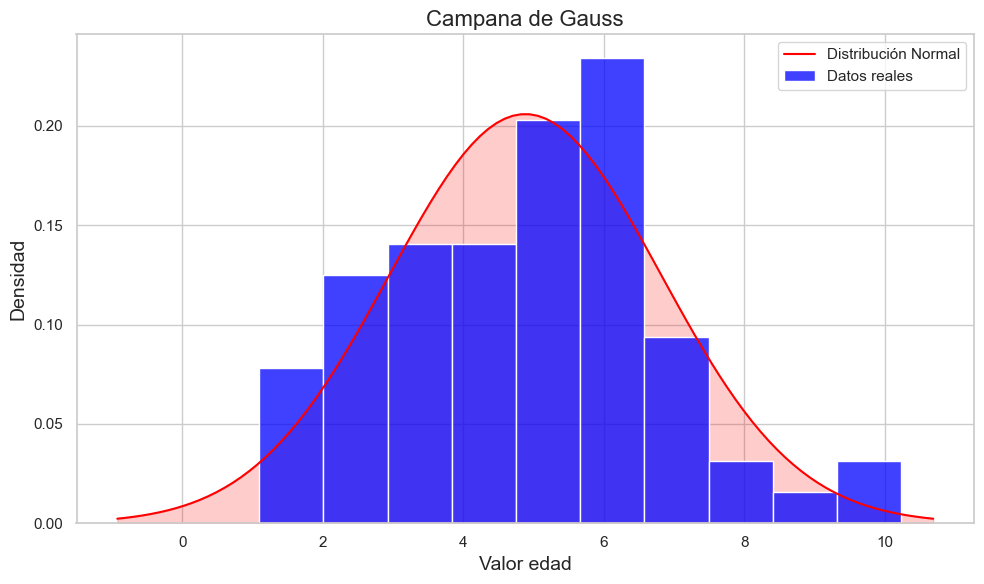

49.86297160067531
15.825733125452743


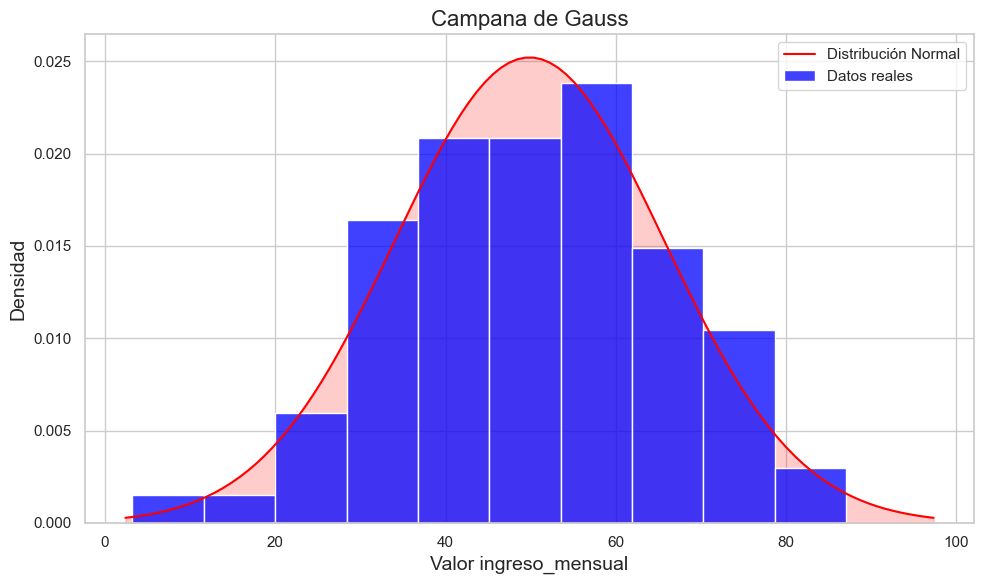

447.7922077922078
206.7449233134997


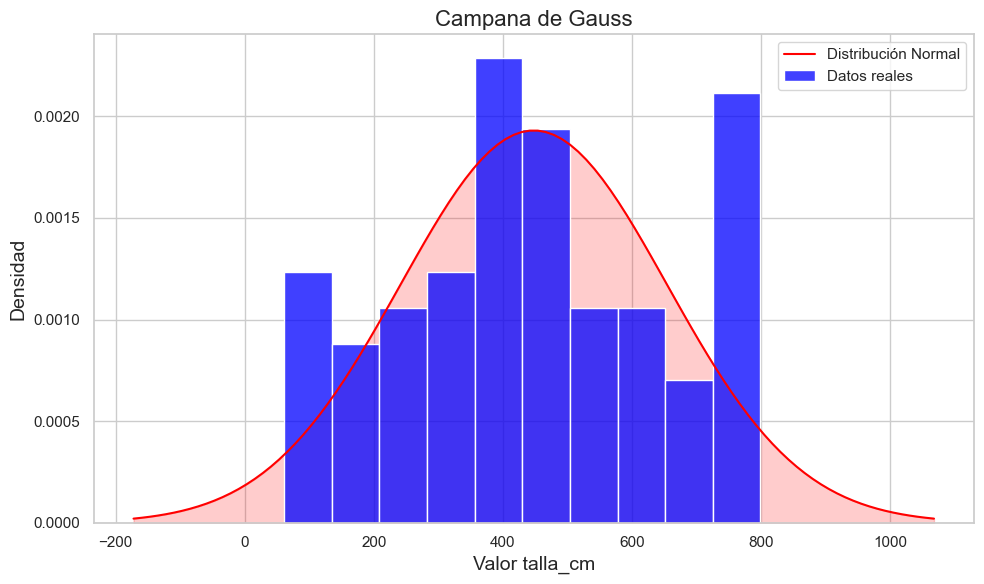

14.847058823529412
5.294849622600396


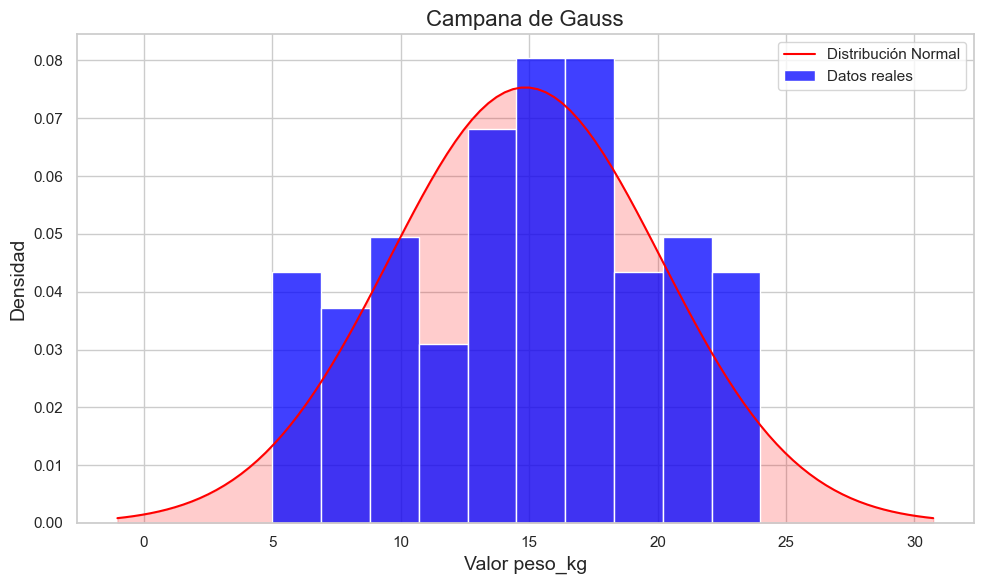

1238.687479429547
242.15033036978696


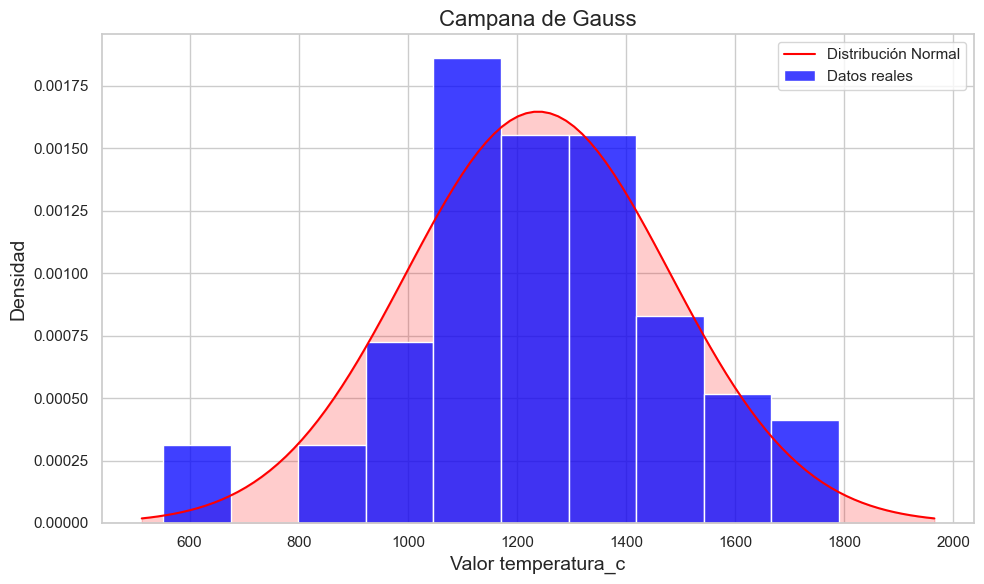

0.651529582915855
0.31723285498318077


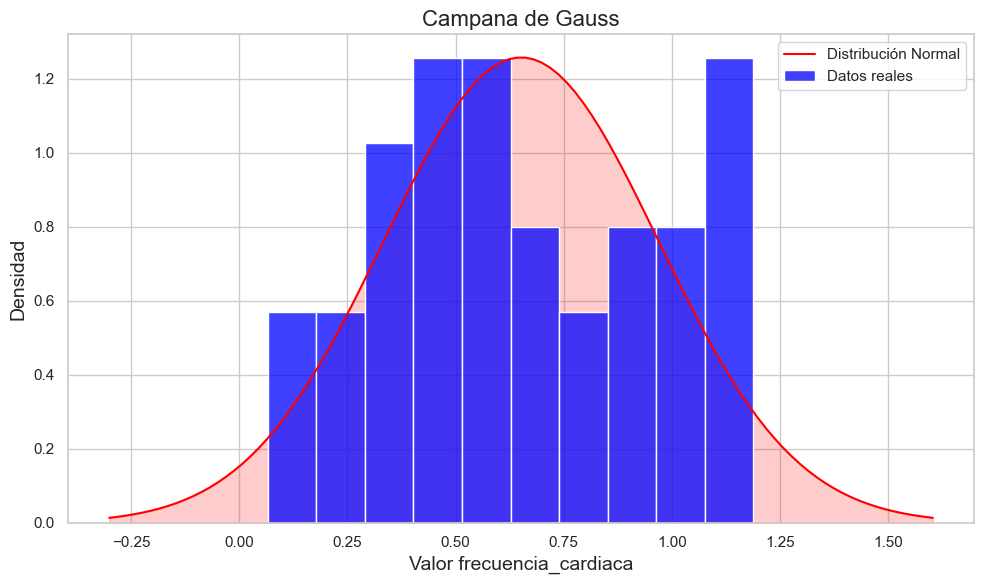

In [36]:
columns = ['edad','ingreso_mensual','talla_cm','peso_kg','temperatura_c','frecuencia_cardiaca']
def hist_dist_normal(df, column):

    escalado = df[column]

    media = np.mean(escalado)
    desviacion = np.std(escalado)
    print(media)
    print(desviacion)

    x = np.linspace(media - 3*desviacion, media + 3*desviacion, 100)
    y = norm.pdf(x, media, desviacion)

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    plt.plot(x, y, color='red', label='Distribución Normal')
    plt.fill_between(x, y, color='red', alpha=0.2)

    sns.histplot(escalado, kde=False, stat='density', bins=10, color='blue', edgecolor='white', label='Datos reales')

    plt.title('Campana de Gauss', fontsize=16)
    plt.xlabel('Valor {}'.format(column), fontsize=14)
    plt.ylabel('Densidad', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()
for column in columns:
    hist_dist_normal(X_train,column)

# Deteccion de Outliers

In [56]:
def outliers_summary(df_in: pd.DataFrame, numeric_cols):
    rows = []
    for col in numeric_cols:
        s_raw = pd.to_numeric(df_in[col], errors='coerce')
        s = s_raw.dropna()

        #formato empty para mostrar lo que se necesita para aplicar la heuristica
        if s.empty:
            rows.append({
                "outliers_n": 0, "outliers_%": 0.0, "|skew|": np.nan,
                "recom_imputer": "median", "imputer_to_use": "RobustScaler"
            })
            continue

        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        #rango intercuartilar
        iqr = q3 - q1
        #limites
        lim_inf, lim_sup = q1 - 1.5*iqr, q3 + 1.5*iqr
        #mascara para contar los outliers
        mask = (s < lim_inf) | (s > lim_sup)
        out_n = int(mask.sum())
        out_pct = 100.0 * out_n / len(s)

        skew_abs = float(abs(s.skew()))

        # Heurística de IMPUTACIÓN
        imputer = "median" if (out_pct >= 5.0 or skew_abs >= 1.0) else "mean"
        # Heurística de ESCALADO
        if out_pct >= 5.0:
            scaler = "RobustScaler"
        elif skew_abs <= 0.5:
            scaler = "StandardScaler"
        else:
            scaler = "MinMaxScaler"

        rows.append({
            "| columna |": col,
            "| outliers_n |": out_n, "outliers_%": round(out_pct, 2),
            "| skew |": round(skew_abs, 3),
            "imputer_to_use": imputer,
            "scaler_to_use": scaler
        })

    rep = pd.DataFrame(rows).sort_values("outliers_%", ascending=False).reset_index(drop=True)
    return rep


print(outliers_summary(X_train,num_cols))

           | columna |  | outliers_n |  outliers_%  | skew | imputer_to_use  \
0        temperatura_c               3        3.85     0.282           mean   
1      ingreso_mensual               1        1.25     0.174           mean   
2                 edad               0        0.00     0.203           mean   
3             talla_cm               0        0.00     0.008           mean   
4              peso_kg               0        0.00     0.192           mean   
5  frecuencia_cardiaca               0        0.00     0.057           mean   
6    sensor_defectuoso               0        0.00     0.734           mean   

    scaler_to_use  
0  StandardScaler  
1  StandardScaler  
2  StandardScaler  
3  StandardScaler  
4  StandardScaler  
5  StandardScaler  
6    MinMaxScaler  


# g) Selección manual de columnas para StandardScaler

In [ ]:
# Según el análisis de outliers y la heurística:
# StandardScaler se aplica a columnas con outliers < 5% y |skew| <= 0.5

standard_scaler_cols = [
    'edad',                  # 0% outliers, skew=0.259
    'ingreso_mensual',       # 1.35% outliers, skew=0.114
    'talla_cm',              # 0% outliers, skew=0.007
    'peso_kg',               # 0% outliers, skew=0.185
    'temperatura_c',         # 4.05% outliers, skew=0.312
    'frecuencia_cardiaca'    # 0% outliers, skew=0.082
]

print("Columnas seleccionadas para StandardScaler:")
print(standard_scaler_cols)

Columnas seleccionadas para StandardScaler:
['edad', 'ingreso_mensual', 'talla_cm', 'peso_kg', 'temperatura_c', 'frecuencia_cardiaca']


# h) Selección manual de columnas para MinMaxScaler

In [ ]:
# Según el análisis de outliers y la heurística:
# MinMaxScaler se aplica cuando no hay muchos outliers pero |skew| > 0.5

minmax_scaler_cols = [
    'sensor_defectuoso'  # 0% outliers, skew=0.734 (entre 0.5 y 1.0)
]

print("Columnas seleccionadas para MinMaxScaler:")
print(minmax_scaler_cols)

Columnas seleccionadas para MinMaxScaler:
['sensor_defectuoso']


# i) Aplicar escalamiento StandardScaler

In [ ]:
# Aplicar StandardScaler a las columnas seleccionadas
# IMPORTANTE: fit() solo con X_train para evitar fuga de datos

scaler_standard = StandardScaler()

# Ajustar el scaler SOLO con datos de entrenamiento
scaler_standard.fit(X_train[standard_scaler_cols])

# Transformar tanto train como test
X_train_standard_scaled = scaler_standard.transform(X_train[standard_scaler_cols])
X_test_standard_scaled = scaler_standard.transform(X_test[standard_scaler_cols])

# Convertir a DataFrame para facilitar manipulación
X_train_standard_df = pd.DataFrame(
    X_train_standard_scaled,
    columns=standard_scaler_cols,
    index=X_train.index
)

X_test_standard_df = pd.DataFrame(
    X_test_standard_scaled,
    columns=standard_scaler_cols,
    index=X_test.index
)

print("StandardScaler aplicado correctamente.")
print(f"Shape X_train escalado: {X_train_standard_df.shape}")
print(f"Shape X_test escalado: {X_test_standard_df.shape}")
print("\nPrimeras filas de X_train escalado:")
print(X_train_standard_df.head())

StandardScaler aplicado correctamente.
Shape X_train escalado: (96, 6)
Shape X_test escalado: (24, 6)

Primeras filas de X_train escalado:
         edad  ingreso_mensual  talla_cm   peso_kg  temperatura_c  \
108  0.269608         0.574274  1.621359 -1.859743      -0.137856   
64  -1.633025         0.192356       NaN  0.028885       0.477814   
9   -1.955682         0.512287  1.384352  0.406610      -0.615636   
95  -0.002921        -0.006133  0.218665  0.973199            NaN   
116       NaN         0.977297 -0.356924 -1.104292            NaN   

     frecuencia_cardiaca  
108            -0.327837  
64             -0.026989  
9                    NaN  
95              0.107031  
116             0.476398  


# j) Aplicar escalamiento MinMaxScaler

In [ ]:
# Aplicar MinMaxScaler a las columnas seleccionadas
# IMPORTANTE: fit() solo con X_train para evitar fuga de datos

scaler_minmax = MinMaxScaler()

# Ajustar el scaler SOLO con datos de entrenamiento
scaler_minmax.fit(X_train[minmax_scaler_cols])

# Transformar tanto train como test
X_train_minmax_scaled = scaler_minmax.transform(X_train[minmax_scaler_cols])
X_test_minmax_scaled = scaler_minmax.transform(X_test[minmax_scaler_cols])

# Convertir a DataFrame para facilitar manipulación
X_train_minmax_df = pd.DataFrame(
    X_train_minmax_scaled,
    columns=minmax_scaler_cols,
    index=X_train.index
)

X_test_minmax_df = pd.DataFrame(
    X_test_minmax_scaled,
    columns=minmax_scaler_cols,
    index=X_test.index
)

print("MinMaxScaler aplicado correctamente.")
print(f"Shape X_train escalado: {X_train_minmax_df.shape}")
print(f"Shape X_test escalado: {X_test_minmax_df.shape}")
print("\nPrimeras filas de X_train escalado:")
print(X_train_minmax_df.head())

MinMaxScaler aplicado correctamente.
Shape X_train escalado: (96, 1)
Shape X_test escalado: (24, 1)

Primeras filas de X_train escalado:
     sensor_defectuoso
108                NaN
64                 NaN
9                  NaN
95                 NaN
116                NaN


# Guardar datos numéricos escalados en CSV

In [14]:
# Combinar todas las columnas numéricas escaladas
X_train_scaled = pd.concat([X_train_standard_df, X_train_minmax_df], axis=1)
X_test_scaled = pd.concat([X_test_standard_df, X_test_minmax_df], axis=1)

# Combinar train y test para guardar todo junto
X_scaled_completo = pd.concat([X_train_scaled, X_test_scaled], axis=0)

# Guardar en CSV
X_scaled_completo.to_csv('data/datos_numericos_escalados.csv', index=True)

print("Datos numéricos escalados guardados exitosamente!")
print(f"Shape del dataset completo escalado: {X_scaled_completo.shape}")
print(f"\nColumnas guardadas:")
print(X_scaled_completo.columns.tolist())
print(f"\nPrimeras filas del CSV:")
print(X_scaled_completo.head())

Datos numéricos escalados guardados exitosamente!
Shape del dataset completo escalado: (120, 7)

Columnas guardadas:
['edad', 'ingreso_mensual', 'talla_cm', 'peso_kg', 'temperatura_c', 'frecuencia_cardiaca', 'sensor_defectuoso']

Primeras filas del CSV:
         edad  ingreso_mensual  talla_cm   peso_kg  temperatura_c  \
108  0.269608         0.574274  1.621359 -1.859743      -0.137856   
64  -1.633025         0.192356       NaN  0.028885       0.477814   
9   -1.955682         0.512287  1.384352  0.406610      -0.615636   
95  -0.002921        -0.006133  0.218665  0.973199            NaN   
116       NaN         0.977297 -0.356924 -1.104292            NaN   

     frecuencia_cardiaca  sensor_defectuoso  
108            -0.327837                NaN  
64             -0.026989                NaN  
9                    NaN                NaN  
95              0.107031                NaN  
116             0.476398                NaN  


# Consluiones

### **Diego Lemus**:
#### Realicé un preprocesamiento sistemático para asegurar la calidad e integridad de los datos: separé primero en entrenamiento y prueba para evitar fuga, analicé distribución y atípicos, y apliqué una heurística coherente para imputar y escalar. Las variables categóricas se codificaron de forma adecuada (ordinal y one-hot) y todo el pipeline se ajustó solo con entrenamiento y luego se aplicó a prueba. Con ello obtuve un dataset consistente, limpio y reproducible, listo para cualquier modelo posterior.

### **Sebastien Zinchenko**:
#### Este ejercicio me enseñó que preparar datos correctamente requiere dividir train/test antes de cualquier transformación para evitar contaminar los resultados, y que cada columna necesita un tratamiento específico según sus características. Lo más valioso fue aprender a observar los datos, tomar decisiones fundamentadas con evidencia del análisis, y entender que el preprocesamiento no es aplicar recetas sino interpretar lo que los datos realmente necesitan.

### **Jesus Vargas**: